# Chapters 11 & 12: - Model Selection & Metrics and Classification Evaluation

In [2]:
# Basic Libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

In [3]:
# Specific Libraries

from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

### The Dataset

In [5]:
# Titanic Dataframe

url = ("https://raw.githubusercontent.com/joanby/python-ml-course/refs/heads/master/datasets/titanic/titanic3.csv")
df = pd.read_csv(url)
orig_df = df

In [6]:
from sklearn import model_selection 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  
from sklearn.preprocessing import StandardScaler 

def tweak_titanic(df):
    # Drop unnecessary columns and convert categorical columns to dummy variables
    df = df.drop(
        columns=[
            "name",          # Drop passenger name column
            "ticket",        # Drop ticket column
            "home.dest",     # Drop home destination column
            "boat",          # Drop boat information column
            "body",          # Drop body number column
            "cabin",         # Drop cabin information column
        ]
    ).pipe(pd.get_dummies, drop_first=True)  # Convert categorical variables to dummy variables, dropping the first category
    return df                                # Return the cleaned and transformed DataFrame

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]               # Extract the target variable
    X = df.drop(columns=y_col)  # Drop target variable from feature set
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(   # Split data into training and test sets
        X, y, test_size=size, random_state=42
    )
    cols = X.columns  # Get list of feature columns
    
    num_cols = [      # List of numeric columns to impute for missing values
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = IterativeImputer()                       # Initialize IterativeImputer for imputing missing values
    fitted = fi.fit_transform(X_train[num_cols])  # Fit and transform imputer on training numeric columns
    
    # Update training DataFrame with imputed values for numeric columns
    X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])  # Transform test data using the same imputer
    
    # Update test DataFrame with imputed values for numeric columns
    X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(num_cols)})
    
    # Standardize specified columns if any are provided
    if std_cols:
        std = StandardScaler()  # Initialize StandardScaler
        fitted = std.fit_transform(X_train[std_cols])  # Fit and transform scaler on training standardization columns
        # Update training DataFrame with standardized values
        X_train = X_train.assign(**{c: fitted[:, i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])     # Transform test data using the same scaler
        # Update test DataFrame with standardized values
        X_test = X_test.assign(**{c: test_fit[:, i] for i, c in enumerate(std_cols)})

    # Return training and test sets for features and target
    return X_train, X_test, y_train, y_test

# Apply the functions to preprocess the Titanic dataset
ti_df = tweak_titanic(orig_df)                 # Clean and transform the original DataFrame
std_cols = "pclass,age,sibsp,fare".split(",")  # Specify columns to standardize

# Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

# Concatenate training and test sets for features and target variables for further use
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# Model Selection

### Validation Curve

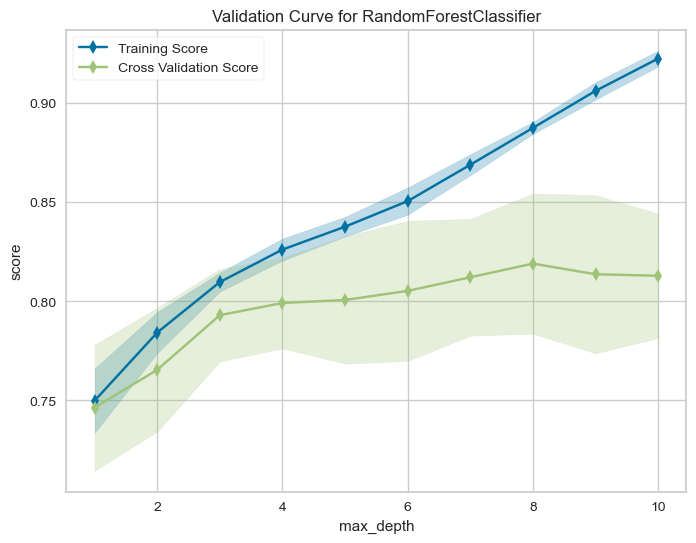

In [9]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import ValidationCurve

# Create a figure and axis with specified size for the validation curve plot
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the ValidationCurve visualizer with the RandomForestClassifier and parameters for evaluation
vc_viz = ValidationCurve(
    RandomForestClassifier(n_estimators=100), # Model to be evaluated (Random Forest with 100 trees)
    param_name="max_depth",                   # Hyperparameter to vary, in this case, the max depth of trees
    param_range=np.arange(1, 11),             # Range of values for max_depth from 1 to 10
    cv=10,                                    # 10-fold cross-validation
    n_jobs=-1                                 # Use all available CPU cores for parallel processing
)

# Fit the visualizer on the full dataset (X, y) to compute the validation curve
vc_viz.fit(X, y)

# Display the validation curve plot
vc_viz.poof(); 

#### Graph Elements

* `x-axis (max_depth)`: Ranges from 1 to 10, representing different values for the maximum depth of the trees in the forest.
* `y-axis (score)`: Shows the model's accuracy score.
* `Blue Line (Training Score)`: Represents the accuracy score on the training set for each max_depth value.
* `Green Line (Cross Validation Score)`: Represents the accuracy score on the cross-validation set (validation score) for each max_depth value.
* `Shaded Areas`: Represent the confidence intervals around the training and cross-validation scores.

#### Observations

Around `max_depth = 6`, the cross-validation score begins to plateau and even shows a slight decline afterward, while the training score continues to increase.

This divergence between the training and cross-validation scores indicates *overfitting*: the model fits the training data very well but starts to perform less consistently on new data as the depth increases further.

The optimal `max_depth` for this model seems to be around 5 or 6. At this point, the cross-validation score is close to its maximum, and there is minimal *overfitting*. The best trade-off between bias and variance for this model, as it achieves high validation accuracy without *overfitting*.

### Learning Curve

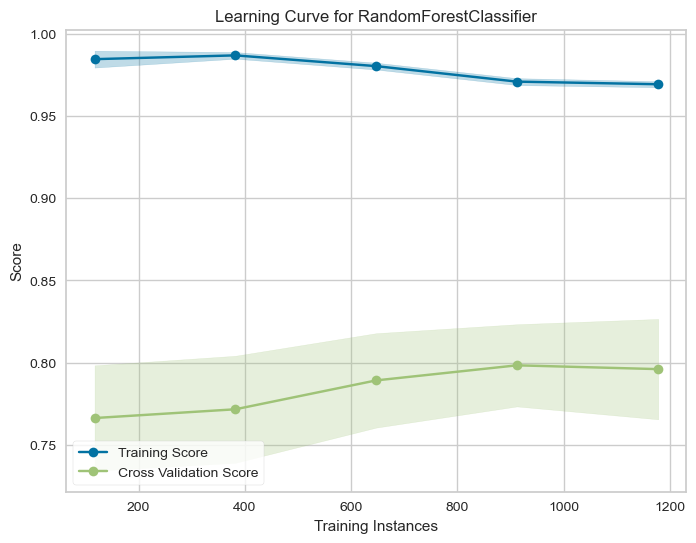

In [13]:
from yellowbrick.model_selection import LearningCurve

# Create a figure and axis with a specified size for the learning curve plot
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the LearningCurve visualizer with a RandomForestClassifier and cross-validation settings
lc3_viz = LearningCurve(
    RandomForestClassifier(n_estimators=100),  # Model to evaluate: Random Forest with 100 trees
    cv=10,                                     # 10-fold cross-validation for evaluating performance stability
)

# Fit the visualizer on the dataset (X, y) to compute learning curves
lc3_viz.fit(X, y)

# Display the learning curve plot
lc3_viz.poof();

Learning curve plot: The plateau in the validation score indicates that adding more data would not improve this model

#### Graph Elements

* `x-axis (Training Instances)`: Represents the number of training samples used to train the model. As more training instances are added, we can observe how the model's performance evolves.
* `y-axis (Score)`: Shows the model's accuracy score.
* `Blue Line (Training Score)`: Represents the accuracy on the training set. It starts high and remains close to 1.0, indicating how well the model fits the training data at each level of training set size.
* `Green Line (Cross Validation Score)`: Represents the accuracy on the cross-validation (test) set, which is the model’s performance on unseen data. It helps indicate the model’s generalization ability.
* `Shaded Areas`: Represent the confidence intervals around the training and validation scores, showing the variability in the scores across different splits.

#### Observations

The cross-validation score is significantly lower than the training score, indicating that the model generalizes less effectively on unseen data.

the gap between the training and validation scores remains large, indicating persistent *overfitting*. The model performs almost perfectly on the training data but does not generalize as well to new, unseen data.

The cross-validation score starts to plateau after around 600 training instances, suggesting that adding more data does not significantly improve the model's performance on unseen data.

# Metrics and Classification Evaluation

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier with specific parameters
dt = DecisionTreeClassifier(
    random_state=42,   # Sets a random seed for reproducibility
    max_depth=3        # Limits the depth of the tree to 3 levels, helping control overfitting by reducing complexity
)

# Train the DecisionTreeClassifier on the training data
dt.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=3, random_state=42)

In [19]:
# Make predictions on the test set using the trained decision tree
y_predict = dt.predict(X_test)

tp = ((y_test == 1) & (y_test == y_predict)).sum()  # Calculate True Positives (TP)
tn = ((y_test == 0) & (y_test == y_predict)).sum()  # Calculate True Negatives (TN)
fp = ((y_test == 0) & (y_test != y_predict)).sum()  # Calculate False Positives (FP)
fn = ((y_test == 1) & (y_test != y_predict)).sum()  # Calculate False Negatives (FN)

# Print the results
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 121
True Negatives (TN): 199
False Positives (FP): 25
False Negatives (FN): 48


In [20]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_predict = dt.predict(X_test)                       

# Create a Dataframe with the confusion matrix
pd.DataFrame(                                        
    confusion_matrix(y_test, y_predict),
    columns=["Predict died","Predict Survive",],
    index=["True Death", "True Survive"]
)

,Predict died,Predict Survive
True Death,199,25
True Survive,48,121


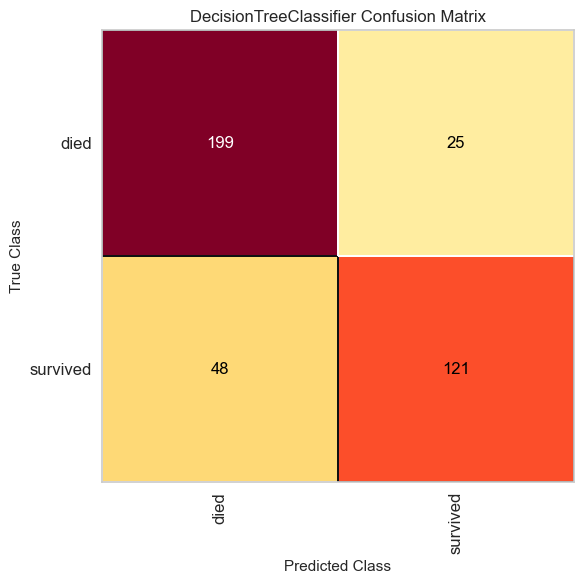

In [21]:
from yellowbrick.classifier import ConfusionMatrix


mapping = {0: "died", 1: "survived"}    # Define a mapping dictionary

fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis

# Initialize the ConfusionMatrix visualizer with the Decision Tree model and custom class labels
cm_viz = ConfusionMatrix(
    DecisionTreeClassifier(random_state=42, max_depth=3),  # Initialize a new Decision Tree model inside the visualizer
    classes=["died", "survived"],                          # List of class names for interpretation
    label_encoder=mapping,                                 # Custom mapping for readable class names
)

# Fit and score the model within the ConfusionMatrix visualizer to avoid attribute issues
cm_viz.fit(X_train, y_train)            # Fit the model directly through the visualizer
cm_viz.score(X_test, y_test)            # Evaluate the model and generate the confusion matrix
cm_viz.poof();                          # Display the confusion matrix plot

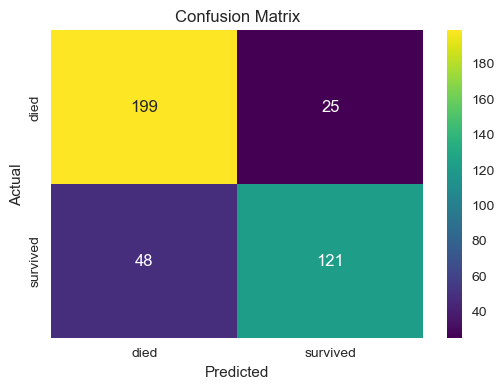

In [22]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['died', 'survived'], yticklabels=['died', 'survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Metrics

### Accuracy

In [25]:
# Accuracy is the percentage of correct classifications
(tp + tn) / (tp + tn + fp + fn)

0.8142493638676844

In [26]:
from sklearn.metrics import accuracy_score

y_predict = dt.predict(X_test)      # Make predictions on the test set using the trained decision tree
accuracy_score(y_test, y_predict)   # Calculate the accuracy of the model

0.8142493638676844

### Recall

In [28]:
# Recall (also called sensitivity) is the percentage of positive values correctly classified
tp / (tp + fn)

0.7159763313609467

In [29]:
from sklearn.metrics import recall_score

y_predict = dt.predict(X_test)    # Make predictions on the test set using the trained decision tree
recall_score(y_test, y_predict)   # Calculate the recall of the model

0.7159763313609467

### Precision

In [31]:
# Precision is the percent of positive predictions that were correct
tp / (tp + fp)

0.8287671232876712

In [32]:
from sklearn.metrics import precision_score

y_predict = dt.predict(X_test)      # Make predictions on the test set using the trained decision tree
precision_score(y_test, y_predict)  # Calculate the precision of the model

0.8287671232876712

### F1

In [34]:
# F1 is the harmonic mean of recall and precision
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)

0.7682539682539683

In [35]:
from sklearn.metrics import f1_score

y_predict = dt.predict(X_test)  # Make predictions on the test set using the trained decision tree
f1_score(y_test, y_predict)     # Calculate F1 of the model

0.7682539682539683

### Classification Report

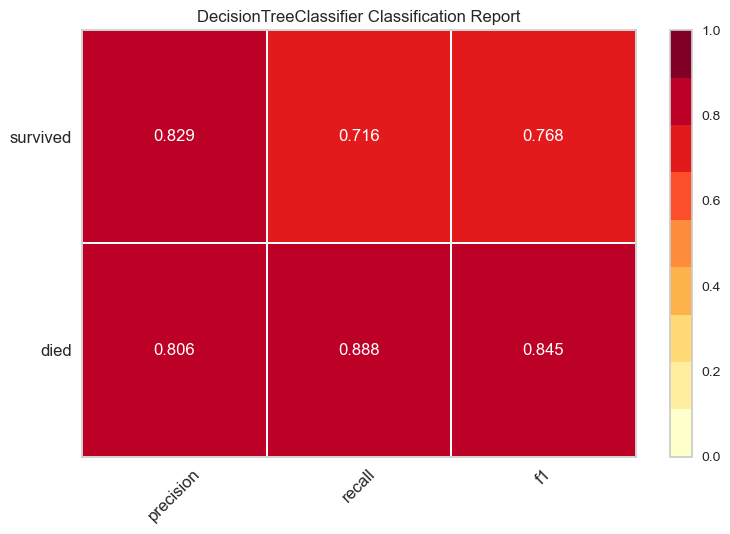

In [37]:
from yellowbrick.classifier import ClassificationReport
from sklearn.tree import DecisionTreeClassifier


# Define the label mapping for interpretability
mapping = {0: "died", 1: "survived"}

# Create a new instance of the DecisionTreeClassifier inside the visualizer
cm_viz = ClassificationReport(
    DecisionTreeClassifier(random_state=42, max_depth=3),  # Initialize model within the visualizer
    classes=["died", "survived"],                          # Class labels for better readability
    label_encoder=mapping,                                 # Label encoder to map 0 to "died" and 1 to "survived"
)

# Fit and score the model within the ClassificationReport visualizer
cm_viz.fit(X_train, y_train)            # Fit the model on the training set
cm_viz.score(X_test, y_test)            # Evaluate and compute metrics on the test set
cm_viz.poof();                          # Display the classification report plot

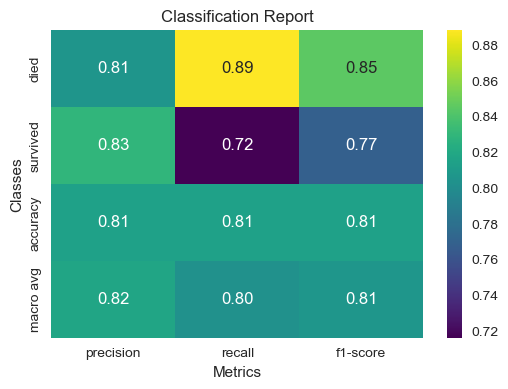

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report
report = classification_report(y_test, y_predict, target_names=["died", "survived"], output_dict=True)

# Convert the report into a DataFrame for easy plotting
report_df = pd.DataFrame(report).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-1, :3], annot=True, cmap="viridis", fmt=".2f", cbar=True)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show();

In [39]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print(classification_report(y_test, y_predict, target_names=["died", "survived"]))

              precision    recall  f1-score   support

        died       0.81      0.89      0.85       224
    survived       0.83      0.72      0.77       169

    accuracy                           0.81       393
   macro avg       0.82      0.80      0.81       393
weighted avg       0.82      0.81      0.81       393



### ROC

A ROC curve illustrates how the classifier performs by tracking
the true positive rate (recall/sensitivity) as the false positive rate
(inverted specificity) changes.

In [42]:
from sklearn.metrics import roc_auc_score

# Generate predictions on the test set using the trained decision tree model
y_predict = dt.predict(X_test)     

# Calculate and return the ROC AUC score for the model's predictions
roc_auc = roc_auc_score(y_test, y_predict)  # Computes the area under the ROC curve
print(f"ROC AUC Score: {roc_auc:.3f}")      # Print the ROC AUC score

ROC AUC Score: 0.802


A rule of thumb is that the plot should bulge out toward the
top-left corner. A plot that is to the left and above another plot
indicates better performance. The diagonal in this plot indicates the behavior of a random guessing classifier. By taking the
AUC, you get a metric for evaluating the performance:

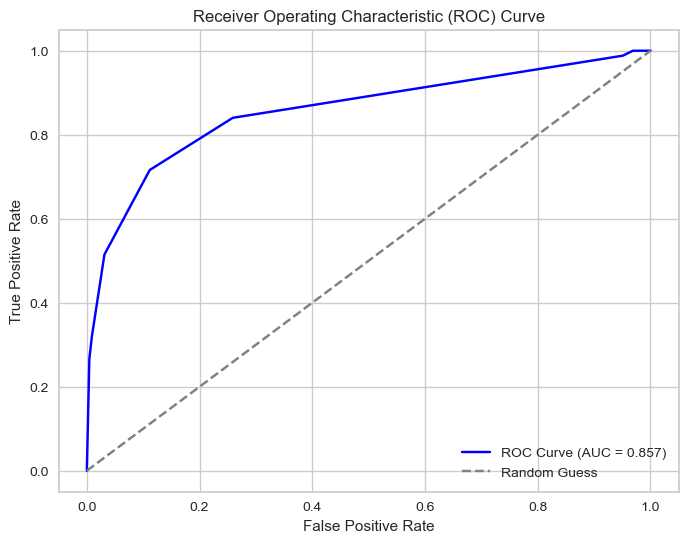

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_pred_proba = dt.predict_proba(X_test)[:, 1]  # Extract probabilities for the positive class

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', color='blue')

# Plot a diagonal line for reference (representing random guessing)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Display the plot
plt.show()

### Precision-Recall Curve

The ROC curve may be overly optimistic for imbalanced
classes. Another option for evaluating classifiers is using a
*precision-recall curve*. Classification is a balancing act of finding everything you need (recall) while limit‐
ing the junk results (precision). This is typically a trade-off. **As
recall goes up, precision usually goes down and vice versa**.

In [47]:
from sklearn.metrics import average_precision_score

# Generate predictions on the test set using the trained decision tree model
y_predict = dt.predict(X_test)                       # Predict class labels for the test data

# Calculate the Average Precision Score for the model's predictions
avg_precision = average_precision_score(y_test, y_predict)  # Computes the average precision score for binary classification
print(f"Average Precision Score: {avg_precision:.3f}")      # Print the average precision score

Average Precision Score: 0.716


Average Precision Score: 0.818


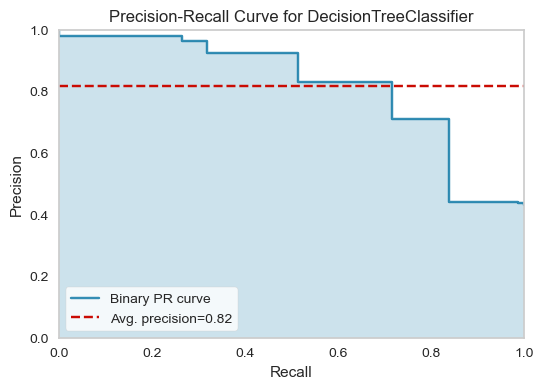

In [48]:
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.tree import DecisionTreeClassifier

fig, ax = plt.subplots(figsize=(6, 4))   # Create a figure and axis

viz = PrecisionRecallCurve(              # Initialize the PrecisionRecallCurve visualizer with a DecisionTreeClassifier
    DecisionTreeClassifier(max_depth=3)  # Initialize a Decision Tree model with max depth of 3
)

viz.fit(X_train, y_train)                             # Fit the visualizer to the training data
avgprecision = viz.score(X_test, y_test)              # Computes the average precision score on the test data
print(f"Average Precision Score: {avgprecision:.3f}") # Print average precision score
viz.poof();                                           # Display the precision-recall curve plot          

Average Precision Score: 0.818


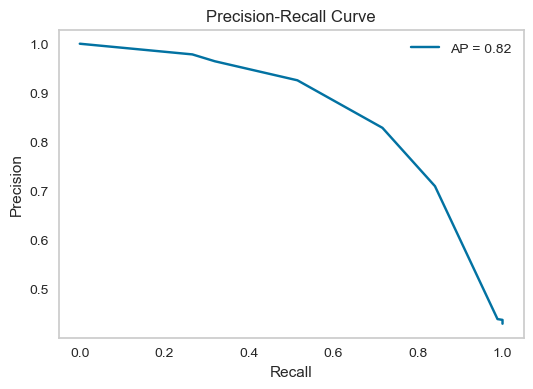

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Predict probabilities for the positive class
y_scores = dt.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (usually index 1)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the average precision score
avg_precision = average_precision_score(y_test, y_scores)
print(f"Average Precision Score: {avg_precision:.3f}")

# Plot the precision-recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid()
plt.show();

### Cumulative Gains Plot

A cumulative gains plot can be used to evaluate a binary classifier. It models the true positive rate (sensitivity) against the support rate (fraction of positive predictions). The intuition behind this plot is to sort all classifications by predicted probability. Ideally there would be a clean cut that divides positive from negative samples. If the first 10% of the predictions has 30% of the positive samples, you would plot a point from (0,0)
to (.1, .3). You continue this process through all of the samples.


A common use for this is determining customer response. The cumulative gains curve plots the support or predicted positive rate along the x-axis. Our chart labels this as “Percentage of sample”. It plots the sensitivity or true positive rate along the yaxis. This is labeled as “Gain” in our plot. If you wanted to contact 90% of the customers that would respond (sensitivity), you can trace from .9 on the y-axis to the right until you hit that curve. The x-axis at that point will indicate how many total customers you need to contact (support) to get to 90%.


In this case we aren’t contacting customers that would respond to a survey but predicting survival on the Titanic. If we ordered all passengers on the Titanic according to our model by how likely they are to survive, if you took the first 65% of them, you would have 90% of the survivors. If you have an associated cost per contact and revenue per response, you can calculate what the best number is.


In general, a model that is to the left and above another model is a better model. The best models are lines that go up to the top (if 10% of the samples are positive, it would hit at (.1, 1)) and then directly to the right. If the plot is below the baseline, we would do better to randomly assign labels that use our model.

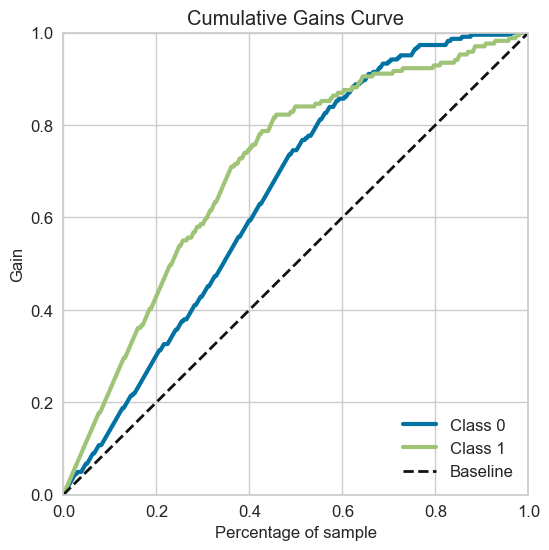

In [51]:
import scikitplot                                 

fig, ax = plt.subplots(figsize=(6, 6))    # Create a figure and axis with a 6x6 inch size for plotting

# Generate predicted probabilities for each class on the test set
y_probas = dt.predict_proba(X_test)       # Get probabilities for each class from the trained Decision Tree model

# Plot the cumulative gain curve
scikitplot.metrics.plot_cumulative_gain(  # Use scikit-plot's cumulative gain plot to evaluate model effectiveness
    y_test,                               # True labels from the test set for reference in the plot
    y_probas,                             # Predicted probabilities for each class from the model
    ax=ax                                 # Specify the axis to draw the cumulative gain plot on
);

Cumulative gains plot: If we ordered people on the Titanic
according to our model, looking at 20% of them we would get 40% of
the survivors.

#### Graph Elements

* `x-axis (Percentage of Sample)`: Represents the percentage of the test set samples, ordered by the likelihood of belonging to each class according to the model. As you move from left to right, you are including a larger portion of the dataset.
* `y-axis (Gain)`: Represents the cumulative proportion of actual positives (or another target class) that are correctly captured by the model as more of the sample is included.
* `Curves for Each Class`:
    * `Class 0 Curve (Blue Line)`: Shows the cumulative gain for Class 0. It indicates the percentage of Class 0 instances captured as we move through the sorted predictions.
    * `Class 1 Curve (Green Line)`: Shows the cumulative gain for Class 1 in a similar manner.
* `Baseline (Dashed Line)`: Represents random selection. For example, by selecting 50% of the dataset randomly, you would expect to capture 50% of the positive instances. This line serves as a baseline for model performance.

#### Insights
* **Model Effectiveness**: The cumulative gains for both classes exceed the baseline, confirming that the model effectively distinguishes between classes.
* **Class Prioritization**: Since the model reaches 80% for Class 1 with fewer samples than it does for Class 0, it might be prioritizing Class 1. If Class 1 represents a more important class (e.g., high-risk or high-value), this behavior is advantageous.
* **Potential for Early Stopping**: In scenarios where the cost of processing more instances is high, you could stop after covering a certain percentage (e.g., 50% of the sample) and still capture a large portion of the positive instances.

### Lift Curve
A lift curve is another way of looking at the information in a
cumulative gains plot. The lift is how much better we are doing
than the baseline model. In our plot below, we can see that if
we sorted our Titanic passengers by the survival probability
and took the first 20% of them, our lift would be about 2.2
times (the gain divided by sample percent) better than randomly choosing survivors. (We would get 2.2
times as many survivors.)

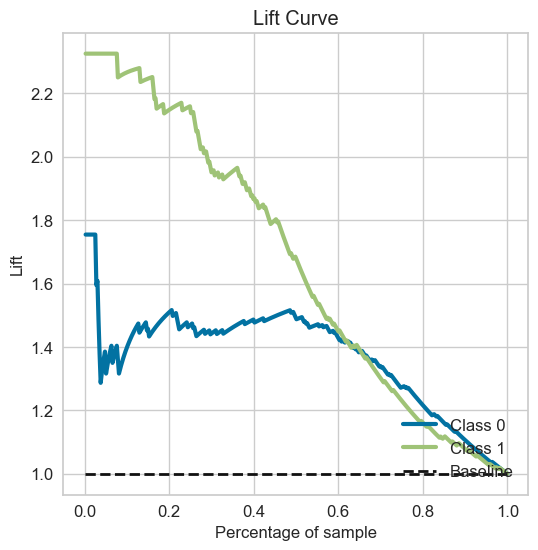

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))             # Create a figure and axis with a 6x6 inch size for plotting

# Generate predicted probabilities for each class on the test set
y_probas = dt.predict_proba(X_test)                # Get probabilities for each class from the trained Decision Tree model

# Plot the lift curve
scikitplot.metrics.plot_lift_curve(                # Use scikit-plot's lift curve plot to assess model effectiveness
    y_test,                                        # True labels from the test set for reference in the plot
    y_probas,                                      # Predicted probabilities for each class from the model
    ax=ax                                          # Specify the axis to draw the lift curve on
);

#### Graph Elements

`x-axis (Percentage of Sample)`: Shows the percentage of the test set samples, sorted in descending order of predicted probability for each class. As you move from left to right, more of the sample is included.

`y-axis (Lift)`: Indicates the lift score, which measures how much more likely you are to find a positive instance in a given portion of the sample compared to random selection. Higher values indicate stronger predictive performance.

`Class 0 Curve (Blue Line)`: Represents the lift for identifying Class 0.

`Class 1 Curve (Green Line)`: Represents the lift for identifying Class 1.

`Baseline (Dashed Line)`: Represents a random model with no predictive power. The lift for a random model is always 1, as it has no advantage over random guessing.

#### Lift Above Baseline:

* For both Class 0 and Class 1, the lift starts significantly above 1, indicating that the model is able to identify positive instances for each class more effectively than random selection.

* Higher lift values mean that, by targeting the top predictions, the model provides better results compared to random sampling.

#### Class 1 (Green Line):

* The lift for Class 1 starts around 2.2, meaning that in the top portion of the sample, the model is over twice as effective as random selection at identifying Class 1 instances.
* The lift for Class 1 decreases as more of the sample is included, eventually converging to 1, which indicates that if we include the entire dataset, the model performs no better than random guessing overall.
* The initial high lift for Class 1 shows that the model effectively ranks instances of Class 1 highly, making it suitable for applications where targeting the top-ranked instances of Class 1 is beneficial.

#### Class 0 (Blue Line):

* The lift for Class 0 also starts above 1, but slightly lower than Class 1. This indicates that the model performs well for Class 0, but not as strongly as for Class 1.
* The lift decreases steadily and converges to the baseline (1) as more of the sample is included, similar to Class 1.
* This suggests that while the model is effective at identifying Class 0, its performance for this class is somewhat less pronounced than for Class 1 in the top-ranked samples.

#### Conclusion

The model is particularly effective in identifying instances of Class 1 with a high lift initially, which suggests that it could be useful in scenarios where focusing on the top-ranked predictions is important. The decreasing lift also implies that the model is best utilized by targeting a subset of the data (top-ranked samples) rather than the entire dataset for optimal efficiency.

### Class Balance

Yellowbrick has a simple bar plot to view the class sizes. When
the relative class sizes are different, accuracy is not a good evaluation metric. When splitting up the data into
training and test sets, use stratified sampling so the sets keep a
relative proportion of the classes. (The `test_train_split` function does this when you set the stratify parameter to the
labels.)

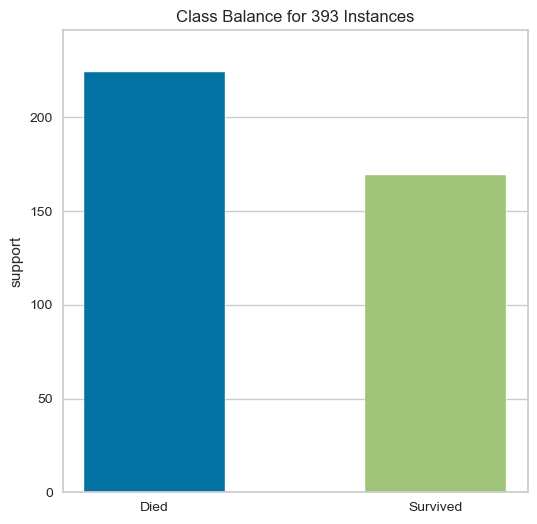

In [62]:
from yellowbrick.classifier import ClassBalance 

fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis with a 6x6 inch size for the plot

# Initialize the ClassBalance visualizer with custom labels
cb_viz = ClassBalance(
    labels=["Died", "Survived"]         # Specify class labels for readability in the visualization
)

# Fit the visualizer on the true labels from the test set
cb_viz.fit(y_test)                      # Provide the true labels to visualize class distribution

# Display the class balance plot
cb_viz.poof();                          # Use 'show()' if 'poof()' is deprecated in your version

This code visualizes the class distribution of `y_test`, helping to identify if the dataset is balanced or imbalanced. Class imbalance can impact model performance, and this plot provides a quick way to check the representation of each class in the test set.

### Class Prediction Error

The class prediction error plot from Yellowbrick is a bar chart that visualizes a confusion matrix :

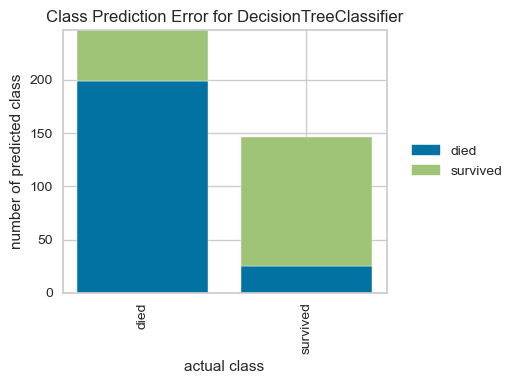

In [66]:
from yellowbrick.classifier import ClassPredictionError
from sklearn.tree import DecisionTreeClassifier


# Create a new figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Initialize the ClassPredictionError visualizer with a new Decision Tree model instance and class labels
cpe_viz = ClassPredictionError(
    DecisionTreeClassifier(random_state=42, max_depth=3),  # Define the model directly within the visualizer
    classes=["died", "survived"]                           # Human-readable labels for each class
)

# Fit and score the model using the visualizer to avoid attribute issues
cpe_viz.fit(X_train, y_train)          # Fits the model on the training data through the visualizer
cpe_viz.score(X_test, y_test)          # Evaluates the model on the test set and generates the prediction error plot
cpe_viz.poof();                        # Displays the plot

### Discrimination Threshold

Most binary classifiers that predict probability have a discrimination threshold of 50%. If the predicted probability is above
50%, the classifier assigns a positive label. Figure 12-10 moves
that threshold value between 0 and 100 and shows the impact
to precision, recall, f1, and queue rate.
    
This plot can be useful to view the trade-off between precision
and recall. Assume we are looking for fraud (and considering
fraud to be the positive classification). To get high recall (catch
all of the fraud), we can just classify everything as fraud. But in
a bank situation, this would not be profitable and would
require an army of workers. To get high precision (only catch
fraud if it is fraud), we could have a model that only triggers on
cases of extreme fraud. But this would miss much of the fraud
that might not be as obvious. There is a trade-off here.
    
The queue rate is the percent of predictions above the threshold. You can consider this to be the percent of cases to review
if you are dealing with fraud.
    
If you have the cost for positive, negative, and erroneous calculations, you can determine what threshold you are comfortable
with.

The following plot is useful to see what discrimination threshold will maximize the f1 score or adjust precision or recall to
an acceptable number when coupled with the queue rate.

Yellowbrick provides this visualizer. This visualizer shuffles the
data and runs 50 trials by default, splitting out 10% for
validation:

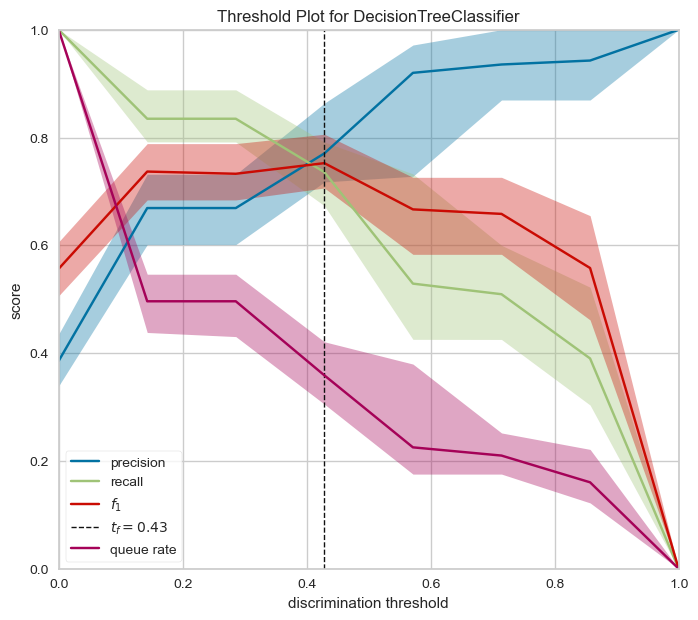

In [69]:
import warnings
from yellowbrick.classifier import DiscriminationThreshold

# Suppress specific warning within a context
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="X does not have valid feature names")
    
    # Code that triggers the warning
    fig, ax = plt.subplots(figsize=(8, 7))  # Create a figure and axis
    dt_viz = DiscriminationThreshold(dt)    # Initialize the DiscriminationThreshold visualizer with the trained Decision Tree model
    dt_viz.fit(X, y)                        # Fit the visualizer on the entire dataset
    dt_viz.poof();                          # Display the discrimination threshold plot

This Threshold Plot for DecisionTreeClassifier visualizes how the performance metrics of the model change as the classification threshold is varied. Adjusting the threshold can impact the balance between precision and recall, and this plot helps to analyze these trade-offs to find an optimal threshold for your specific goals.

This plot shows how adjusting the classification threshold affects various metrics, giving you the flexibility to choose a threshold based on the specific needs of your application. The threshold around 0.43 is optimal if you want a balanced performance in terms of both precision and recall, but if you need to prioritize one over the other, the graph provides insights on how to adjust the threshold accordingly.

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 1: Predict probabilities for the positive class (e.g., "survived")
y_proba = dt.predict_proba(X_test)[:, 1]  # Extracts the probabilities for class 1 (positive class)

# Step 2: Apply custom threshold (e.g., 0.43) to make predictions
custom_threshold = 0.43
y_pred_custom = np.where(y_proba >= custom_threshold, 1, 0)  # Assign 1 if probability >= threshold, else 0

# Step 3: Evaluate with custom threshold predictions
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)

print(f" Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"   Recall: {recall:.3f}")

 Accuracy: 0.814
Precision: 0.829
   Recall: 0.716
